# A Deep Learning Approach to Safeguard Coral Reefs: Detecting Crown-of-Thorn Starfish in Underwater Footage
## Part 2/2: Training & Results
<h1><center>By: Ken K. Hong, Oanh Doan</center></h1>


# 2. Approach

## 2.1. Data Processing

In this project, we first performed exploratory data analysis (EDA) to examine the dataset in detail, as described in the background section and Part 1. Next, we addressed the issue of label format incompatibility. The original dataset provided bounding box annotations using the pixel coordinates of the upper-left corner (x_min, y_min), along with the box’s width and height in pixels. We modified this setup to meet YOLO’s required format, which uses the coordinates of the bounding box’s center (x_center, y_center) and normalizes all coordinates and box measurements with respect to the original image’s width and height. Hence, all normalized values are bounded between 0 and 1.

In addition to label conversion, we filtered the dataset to include only frames containing annotations. Unlabeled frames did not provide valuable information for training. Frames without bounding boxes often act as negative examples, which, when excessive, can lead to unbalanced learning, degraded model performance, and computational inefficiency. According to Table 1, applying this filter results in a dataset of **4919 images** for both training and validation.

For the training and fine-tuning processes, **video0** and **video1** (4242 images) are used as the training dataset, and **video2** (677 images) is reserved for validation. This dataset splitting approach provides a more reliable evaluation of the object detection model’s performance and helps reduce the risk of overfitting to the training data. Additionally, instead of a random 80/20 split, a video-based split is used to prevent data leakage, as images from the same video sequence show high similarity.

<br>
<center>
  <h3> </h3>

  <h3><center>Table 1: Data Distribution of Annotated Frames per Video </center></h3>

| **Video ID** | **Total Frames** | **Frames with Bounding Boxes** | **% of Annotated Frames** |
|:-------------:|:----------------:|:------------------------------:|:-------------------------:|
| 0             | 6708             | 2143                           | 31.95%                    |
| 1             | 8232             | 2099                           | 25.50%                    |
| 2             | 8561             | 677                            | 7.91%                     |
| **Total**     | **23501**        | **4919**                       | **20.9%**                 |




<br>


</center>

---

## 2.2. Model

We chose to use **YOLOv11** [4] by Ultralytics, a state-of-the-art object detection model known for outperforming others in accuracy and efficiency. YOLOv11 is particularly well-suited for object detection tasks due to its real-time inference capabilities and superior performance in detecting small and intricate objects.

We began our experiments with the YOLOv11 **nano model**, which is optimized for lightweight, efficient training and inference. We trained the model for 10 epochs using default hyperparameters and an input image size of 640. The model resulted in a **mAP50 of 0.3**, which was a promising signal of the model’s potential. Building on these results, we decided to scale up to YOLOv11 **small** as our baseline model and experiment with larger models, including YOLOv11 **medium**, **large**, and even **X-large**. We hypothesize that larger models, equipped with more complex layers, are better at capturing low-level details, which would lead to improved model performance. This is particularly important for our task, where the starfish blend seamlessly into the coral reef and have subtle features that can be difficult to distinguish.

Apart from the model size, we also tested various hyperparameters, including the use of **cosine learning rate scheduling** and the **Adam optimizer** with weight decay. A detailed discussion of hyperparameter tuning experiments is provided in Table 3.

Beyond tuning hyperparameters to optimize the baseline model, we attempted two techniques to further enhance model performance:

1. **Dummy Classes for Regularization**: We added dummy classes to the output layer as a form of regularization. We magnified the number of prediction classes, but no actual labels were created for these dummy classes. We expected this technique to reduce overfitting and force the model to generalize better to unseen data.

2. **Integration of CBAM (Convolutional Block Attention Module)**: We integrated CBAM to refine the feature extraction process. Specifically, we inserted CBAM into the first two **C3K2 layers** in the YOLO model, which are part of the model backbone and responsible for feature extraction. With this update, CBAM processes the output of the original C3K2 layers to suppress irrelevant information before passing it on to the next layer.

   We chose to insert CBAM into only the first two C3K2 layers for two main reasons:
   - They operate at early stages of the network, where broader and lower-level features are extracted.
   - The architecture of these two layers is the same, which reduces friction in implementation.

We opted not to insert CBAM into deeper layers in the network to minimize computational and implementation overhead, particularly when these layers focus on higher-level, abstract features, where the need for attention refinement is less critical.


In [ ]:
# Import Kaggle Data Sources
import kagglehub

# Login to Kaggle
kagglehub.login()

# Note:
# To use Kaggle's API, ensure you have your Kaggle credentials.
# Visit your Kaggle account page, navigate to the API section, and generate a new API token if needed.


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
import torch
import shutil
import os

# Check if GPU is available with PyTorch
gpu_available = torch.cuda.is_available()

# Check if TPU is available in Colab
tpu_available = 'COLAB_TPU_ADDR' in os.environ

# Print out the runtime type
if gpu_available:
    print("Current runtime: GPU")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
elif tpu_available:
    print("Current runtime: TPU")
else:
    print("Current runtime: CPU")
    raise RuntimeError(
        "You are using CPU. Please change the runtime to GPU or TPU in Colab.")

# WARNING ⚠️ :
  # Enable GPU in Colab: First, confirm that you have enabled GPU in Colab. To do this:
  # Go to Runtime > Change runtime type.
  # Under Hardware accelerator, choose GPU and click Save.
  # eg. A100 GPU


Current runtime: GPU
GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
!nvidia-smi


Thu Dec 12 09:02:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              41W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Import and Setup Kaggle Data Sources
# NOTE: This notebook environment differs from Kaggle's Python environment,
# so some libraries used in Kaggle may not be pre-installed here.

# Download the TensorFlow Great Barrier Reef dataset
tensorflow_great_barrier_reef_path = kagglehub.competition_download(
    'tensorflow-great-barrier-reef'
)

# Define source and target paths
source_path = "/root/.cache/kagglehub/competitions/tensorflow-great-barrier-reef"
destination_path = "/content/tensorflow-great-barrier-reef"

# Check if the source path exists
if os.path.exists(source_path):
    # Move the dataset to the target location
    shutil.move(source_path, destination_path)
    print(f"Dataset moved to: {destination_path}")
else:
    print(f"Source directory does not exist: {source_path}")

print("Data source import complete.")

# Estimated times:
# - Download: ~2 mins (14.2 GB at 100 MB/s)
# - Extraction: ~3 mins


100%|██████████| 14.2G/14.2G [01:38<00:00, 154MB/s]

Extracting files...


Dataset moved to: /content/tensorflow-great-barrier-reef
Data source import complete.


In [ ]:
# Import necessary libraries for data processing and visualization

# import gc  # Garbage collection to manage memory
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import random  # For random number generation

# Importing libraries for image processing and display
from IPython.display import display  # For displaying images and outputs
from PIL import Image  # For working with images
import cv2  # OpenCV library for image processing
import matplotlib.pyplot as plt  # For plotting and visualization


In [ ]:
# Load training and test datasets into pandas DataFrames
df = pd.read_csv('../content/tensorflow-great-barrier-reef/train.csv')
# df_test = pd.read_csv('../content/tensorflow-great-barrier-reef/test.csv')

# Create a copy of the original dataframe for transformation
df_transform = df.copy(deep=True)

# Extract image number from 'image_id' and convert to numeric
df_transform['image_id_num'] = df_transform['image_id'].str.split('-').str[1]
df_transform['image_id_num'] = pd.to_numeric(df_transform['image_id_num'])

# Convert annotations from string to list
df_transform['annotations_lst'] = df_transform['annotations'].apply(eval)

# Count the number of annotations for each image
df_transform['annotations_count'] = df_transform['annotations_lst'].apply(len)

# Generate the full file path for each image
df_transform['image_id_loc'] = (
    '../content/tensorflow-great-barrier-reef/train_images/video_'
    + df_transform['video_id'].astype(str) + '/'
    + df_transform['image_id_num'].astype(str) + '.jpg'
)

# Display the first few rows of the transformed dataframe
df_transform.head()


video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   image_id_num annotations_lst  annotations_count  \
0             0              []                  0   
1             1              []                  0   
2             2              []                  0   
3             3              []                  0   
4             4              []                  0   

                                        image_id_loc  
0  ../content/tensorflow-great-barrier-reef/train...  
1  ../content/tensorflow-great-barrier-reef/train...  
2  ../content/tensorflow-great-barrier-reef/train...  
3  ../content/tensorflow-great-barrier-reef/train...  
4  ../content/tensorflow-great-barrier-reef/train...

In [ ]:
def get_image(video_id, video_frame):
    """Helper function to retrieve image from the DataFrame based on video_id and video_frame."""
    try:
        image_path = df_transform[(df_transform['video_id'] == video_id) &
                                  (df_transform['video_frame'] == video_frame)]['image_id_loc'].iloc[0]
        return Image.open(image_path)
    except IndexError:
        raise ValueError(
            f"Image not found for video_id {video_id} and video_frame {video_frame}")


def draw_bounding_boxes(image, bounding_boxes):
    """Draw bounding boxes on the image."""
    # Convert PIL image to OpenCV format (NumPy array)
    img_cv = np.array(image)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

    for bb in bounding_boxes:
        x = int(bb['x'])
        y = int(bb['y'])
        width = int(bb['width'])
        height = int(bb['height'])
        x1 = x + width
        y1 = y + height

        # Draw the rectangle on the image
        cv2.rectangle(img_cv, (x, y), (x1, y1), (134, 0, 255), 2)

    # Convert the image back to PIL format
    img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    return img_pil


def show_COT_img(video_id, video_frame):
    """
    Retrieve the image based on video_id and video_frame without resizing.

    Args:
    video_id (str): The ID of the video.
    video_frame (int): The frame number in the video.

    Returns:
    PIL.Image: The original image.
    """
    img = get_image(video_id, video_frame)
    return img


def show_COT_img_BB(video_id, video_frame):
    """
    Retrieve an image and overlay bounding boxes on it without resizing.

    Args:
    video_id (str): The ID of the video.
    video_frame (int): The frame number in the video.

    Returns:
    PIL.Image: The image with bounding boxes drawn on it.
    """
    img = show_COT_img(
        video_id, video_frame)  # Get original image without resizing

    # Retrieve the bounding box annotations from the DataFrame
    bounding_boxes = df_transform[(df_transform['video_id'] == video_id) &
                                  (df_transform['video_frame'] == video_frame)]['annotations_lst'].iloc[0]

    if bounding_boxes:
        img = draw_bounding_boxes(img, bounding_boxes)

    return img


## Date Preparation & Train/Val Split

In [ ]:
# For interacting with the operating system (file paths, environment variables)
import os
import shutil  # For file operations (copy, move, delete files/folders)
import yaml  # For reading and writing YAML files
from tqdm import tqdm  # For progress bars in loops


In [ ]:
# Filter rows where 'annotations_count' is greater than 0, reset index, and make a copy of the DataFrame
df_train = df_transform[df_transform["annotations_count"]
                        > 0].reset_index(drop=True).copy()

# Display a random sample of 3 rows for inspection
df_train_sample = df_train.sample(n=3, random_state=32)

# Show the sample (optional, useful for debugging)
df_train_sample


video_id  sequence  video_frame  sequence_frame image_id  \
4034         1     60754         9246             830   1-9246   
2765         1      8503         4765             937   1-4765   
206          0     40258          274             274    0-274   

                                            annotations  image_id_num  \
4034  [{'x': 138, 'y': 468, 'width': 68, 'height': 5...          9246   
2765  [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]          4765   
206   [{'x': 1044, 'y': 475, 'width': 43, 'height': ...           274   

                                        annotations_lst  annotations_count  \
4034  [{'x': 138, 'y': 468, 'width': 68, 'height': 5...                  3   
2765  [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]                  1   
206   [{'x': 1044, 'y': 475, 'width': 43, 'height': ...                  1   

                                           image_id_loc  
4034  ../content/tensorflow-great-barrier-reef/train...  
2765  ../content/tensorflow-great-barrier-reef/train...  
206   ../content/tensorflow-great-barrier-reef/train...

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)


def convert_bboxes_to_yolo(bboxes):
    """
    Convert bounding boxes from dictionary format {'x': x, 'y': y, 'width': w, 'height': h}
    to YOLO format: [x_center, y_center, width, height].

    Parameters:
        bboxes (list of dicts): List of bounding box dictionaries.

    Returns:
        list: List of bounding boxes in YOLO format.
    """
    return [[box['x'], box['y'], box['width'], box['height']] for box in bboxes]


# Apply the conversion to bounding boxes and store results in new columns
df_train['annotations_pv'] = df_train['annotations_lst'].apply(
    convert_bboxes_to_yolo)
df_train['annotations_pv_str'] = df_train['annotations_pv'].apply(
    str)  # Convert list to string for easier storage

# Define train-val split based on video_id
# Video IDs 0 and 1 are for training, while video ID 2 is for validation
df_train['split'] = df_train['video_id'].apply(
    lambda x: 'train' if x in [0, 1] else 'val')

# Create paths for images and labels
df_train["image_path"] = (
    "../content/model/"
    + df_train["split"].astype(str) + "/images/video_"
    + df_train["video_id"].astype(str) + "_"
    + df_train["video_frame"].astype(str) + ".jpg"
)

df_train["label_path"] = (
    "../content/model/"
    + df_train["split"].astype(str) + "/labels/video_"
    + df_train["video_id"].astype(str) + "_"
    + df_train["video_frame"].astype(str) + ".txt"
)

# Display a random sample of 3 rows for inspection
df_train_sample = df_train.sample(n=3, random_state=32)

# Show the sample (optional, useful for debugging)
df_train_sample


video_id  sequence  video_frame  sequence_frame image_id  \
4034         1     60754         9246             830   1-9246   
2765         1      8503         4765             937   1-4765   
206          0     40258          274             274    0-274   

                                            annotations  image_id_num  \
4034  [{'x': 138, 'y': 468, 'width': 68, 'height': 5...          9246   
2765  [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]          4765   
206   [{'x': 1044, 'y': 475, 'width': 43, 'height': ...           274   

                                        annotations_lst  annotations_count  \
4034  [{'x': 138, 'y': 468, 'width': 68, 'height': 5...                  3   
2765  [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]                  1   
206   [{'x': 1044, 'y': 475, 'width': 43, 'height': ...                  1   

                                           image_id_loc  \
4034  ../content/tensorflow-great-barrier-reef/train...   
2765  ../content/tensorflow-great-barrier-reef/train...   
206   ../content/tensorflow-great-barrier-reef/train...   

                                         annotations_pv  \
4034  [[138, 468, 68, 51], [340, 596, 41, 36], [191,...   
2765                               [[103, 155, 38, 36]]   
206                               [[1044, 475, 43, 45]]   

                                     annotations_pv_str  split  \
4034  [[138, 468, 68, 51], [340, 596, 41, 36], [191,...  train   
2765                               [[103, 155, 38, 36]]  train   
206                               [[1044, 475, 43, 45]]  train   

                                          image_path  \
4034  ../content/model/train/images/video_1_9246.jpg   
2765  ../content/model/train/images/video_1_4765.jpg   
206    ../content/model/train/images/video_0_274.jpg   

                                          label_path  
4034  ../content/model/train/labels/video_1_9246.txt  
2765  ../content/model/train/labels/video_1_4765.txt  
206    ../content/model/train/labels/video_0_274.txt

In [ ]:
# Extract unique 'split' values and their counts for video_ids 0, 1, and 2
video_ids = [0, 1, 2]

# Iterate over each video_id and print split counts and unique values
for video_id in video_ids:
    # Filter the DataFrame for the current video_id and count occurrences of each 'split'
    split_counts = df_train[df_train['video_id']
                            == video_id]['split'].value_counts()
    unique_splits = split_counts.index.tolist()

    # Print the unique splits and their counts for the current video_id
    print(f"Unique 'split' values for video_id == {video_id}: {unique_splits}")
    print(f"Counts for video_id == {video_id}:\n{split_counts}\n")


Unique 'split' values for video_id == 0: ['train']
Counts for video_id == 0:
split
train    2143
Name: count, dtype: int64

Unique 'split' values for video_id == 1: ['train']
Counts for video_id == 1:
split
train    2099
Name: count, dtype: int64

Unique 'split' values for video_id == 2: ['val']
Counts for video_id == 2:
split
val    677
Name: count, dtype: int64



In [ ]:
with pd.option_context('display.max_colwidth', None):
    # Print the image_id_loc at index 13000
    print(df_train.iloc[2765])


video_id                                                                                   1
sequence                                                                                8503
video_frame                                                                             4765
sequence_frame                                                                           937
image_id                                                                              1-4765
annotations                                [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]
image_id_num                                                                            4765
annotations_lst                            [{'x': 103, 'y': 155, 'width': 38, 'height': 36}]
annotations_count                                                                          1
image_id_loc          ../content/tensorflow-great-barrier-reef/train_images/video_1/4765.jpg
annotations_pv                                                        

In [ ]:
# Create necessary directories for train and validation images/labels
os.makedirs('../content/model/train/images', exist_ok=True)
os.makedirs('../content/model/train/labels', exist_ok=True)
os.makedirs('../content/model/val/images', exist_ok=True)
os.makedirs('../content/model/val/labels', exist_ok=True)

# Print current directory structure
print("Directory Structure before cleanup:")
print(os.listdir("../content/model"))


def remove_all_in_dir(directory):
    """
    Remove all contents from the specified directory.
    If the directory doesn't exist, print an error message.

    Parameters:
        directory (str): The directory path to clean.
    """
    if os.path.exists(directory):
        # Iterate over the files and subdirectories
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                # Remove directories and files
                if os.path.isdir(file_path):
                    # Recursively delete directory and its contents
                    shutil.rmtree(file_path)
                else:
                    os.remove(file_path)  # Remove individual file
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")
    else:
        print(f"The directory {directory} does not exist.")


# Clean the directories for train and validation images/labels
remove_all_in_dir('../content/model/train/images')
remove_all_in_dir('../content/model/train/labels')
remove_all_in_dir('../content/model/val/images')
remove_all_in_dir('../content/model/val/labels')

# Confirm that the directories are empty
print("Directory Structure after cleanup:")
print(f"Train images: {os.listdir('../content/model/train/images')}")
print(f"Train labels: {os.listdir('../content/model/train/labels')}")
print(f"Val images: {os.listdir('../content/model/val/images')}")
print(f"Val labels: {os.listdir('../content/model/val/labels')}")


Directory Structure before cleanup:
['train', 'val']
Directory Structure after cleanup:
Train images: []
Train labels: []
Val images: []
Val labels: []


In [ ]:
# Iterate over image paths and locations from the DataFrame
for path, path_image in tqdm(zip(df_train["image_id_loc"], df_train["image_path"]), total=len(df_train)):
    # Get the destination directory from the image path
    dst_dir = os.path.dirname(path_image)

    # Create the destination directory if it doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Copy the image from source to destination
    shutil.copy(src=path, dst=path_image)


100%|██████████| 4919/4919 [00:06<00:00, 751.67it/s]


In [ ]:
# Get the list of files in the 'train/images' and 'val/images' directories
train_files = os.listdir("../content/model/train/images/")
val_files = os.listdir("../content/model/val/images/")

# Print the total number of files and top 3 files in the 'train/images' directory
print(f"Total files in 'train/images': {len(train_files)}")
print(f"Top 3 files in 'train/images': {train_files[:3]}")

# Print the total number of files and top 3 files in the 'val/images' directory
print(f"Total files in 'val/images': {len(val_files)}")
print(f"Top 3 files in 'val/images': {val_files[:3]}")


Total files in 'train/images': 4242
Top 3 files in 'train/images': ['video_1_9516.jpg', 'video_0_9519.jpg', 'video_0_4731.jpg']
Total files in 'val/images': 677
Top 3 files in 'val/images': ['video_2_5837.jpg', 'video_2_5954.jpg', 'video_2_5449.jpg']


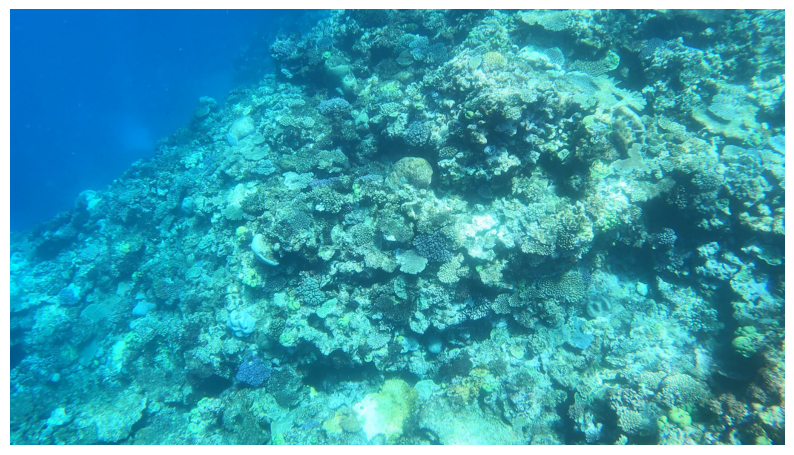

In [ ]:
# Read the image
img_sample = cv2.imread("../content/model/train/images/" + train_files[0])

img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))  # Set figure size
plt.imshow(img_sample)
plt.axis("off")  # Hide axis
plt.show()


In [ ]:
def coco_to_yolo(coco_bboxes, img_width, img_height, class_id=0):
    yolo_bboxes = []
    for bbox in coco_bboxes:
        x_min, y_min, width, height = bbox

        # Calculate xmax and ymax
        x_max = x_min + width
        y_max = y_min + height

        # Calculate the center of the bounding box
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2

        # Normalize the center and size
        x_center_normalized = x_center / img_width
        y_center_normalized = y_center / img_height
        width_normalized = width / img_width
        height_normalized = height / img_height

        x_center_normalized = np.clip(x_center_normalized, 0, 1)
        y_center_normalized = np.clip(y_center_normalized, 0, 1)
        width_normalized = np.clip(width_normalized, 0, 1)
        height_normalized = np.clip(height_normalized, 0, 1)

        # Convert to YOLO format [class_id, x_center, y_center, width, height]
        yolo_bbox = [class_id, x_center_normalized,
                     y_center_normalized, width_normalized, height_normalized]

        # Add to the list of YOLO formatted bounding boxes
        yolo_bboxes.append(yolo_bbox)

    return yolo_bboxes


# Example usage
# Example COCO bounding boxes
coco_bboxes = [[103, 155, 141, 191], [103, 155, 141, 191]]
img_width = 640  # Example image width
img_height = 480  # Example image height

yolo_bboxes = coco_to_yolo(coco_bboxes, img_width, img_height)

print(yolo_bboxes)


[[0, 0.27109375, 0.521875, 0.2203125, 0.39791666666666664], [0, 0.27109375, 0.521875, 0.2203125, 0.39791666666666664]]


In [ ]:
# Check if all images have the expected size (1280x720)
for image_path in tqdm(df_train["image_id_loc"]):
    with Image.open(image_path) as img:
        width, height = img.size

        # Assert that the width is 1280 and the height is 720
        assert width == 1280, f"Width of {image_path} is {width}, expected 1280."
        assert height == 720, f"Height of {image_path} is {height}, expected 720."


100%|██████████| 4919/4919 [00:00<00:00, 8811.56it/s]


In [ ]:
# Initialize list to store YOLO bounding boxes
yolo_bboxes_lst = []

# Iterate over each sample in the DataFrame
for k in tqdm(range(len(df_train))):
    sample_data = df_train.iloc[k, :]
    # Convert string to list of bounding boxes
    bb_bbox = eval(sample_data["annotations_pv_str"])
    num_bbox = sample_data["annotations_count"]

    # Open the label file for writing
    with open(sample_data["label_path"], 'w') as file:
        if num_bbox == 0:
            file.write("")  # If no bounding boxes, write nothing
            continue

        # Convert COCO bounding boxes to YOLO format (1280x720)
        yolo_bbox = coco_to_yolo(bb_bbox, 1280, 720)
        yolo_bboxes_lst.append(yolo_bbox)

        # Write each YOLO bounding box to the label file
        for i in range(num_bbox):
            # Format the YOLO bbox into a space-separated string
            # Convert numbers to strings
            label_txt = " ".join(map(str, yolo_bbox[i]))
            label_txt = label_txt.strip()  # Remove any leading/trailing spaces

            file.write(label_txt + "\n")  # Write the label to the file

# Store the list of YOLO bounding boxes in the DataFrame
df_train["yolo_bbox_lst"] = yolo_bboxes_lst


100%|██████████| 4919/4919 [00:01<00:00, 2806.06it/s]


In [ ]:
# Get the list of files in the 'train/labels' and 'val/labels' directories
train_files = os.listdir("../content/model/train/labels/")
val_files = os.listdir("../content/model/val/labels/")

# Print the total number of files and top 3 files in the 'train/labels' directory
print(f"Total files in 'train/labels': {len(train_files)}")
print(f"Top 3 files in 'train/labels': {train_files[:3]}")

# Print the total number of files and top 3 files in the 'val/labels' directory
print(f"Total files in 'val/labels': {len(val_files)}")
print(f"Top 3 files in 'val/labels': {val_files[:3]}")


Total files in 'train/labels': 4242
Top 3 files in 'train/labels': ['video_0_12311.txt', 'video_1_5927.txt', 'video_1_5471.txt']
Total files in 'val/labels': 677
Top 3 files in 'val/labels': ['video_2_5456.txt', 'video_2_7984.txt', 'video_2_5703.txt']


In [ ]:
# Print a sample of 3 labels from the 'labels' folder
print("Sample of 3 labels from the ../labels/ folder:\n")

# Open the first label file from the 'train' and 'val' directories
with open(f'../content/model/train/labels/{train_files[0]}', 'r') as f1, \
        open(f'../content/model/val/labels/{val_files[0]}', 'r') as f2:

    # Print the content of the first label files
    print(f"{train_files[0]}: \n{f1.read()}")
    print(f"{val_files[0]}: \n{f2.read()}")


Sample of 3 labels from the ../labels/ folder:

video_0_12311.txt: 
0 0.810546875 0.8583333333333333 0.03203125 0.04722222222222222

video_2_5456.txt: 
0 0.026171875 0.93125 0.04609375 0.0763888888888889



In [ ]:
# Set display option to show full content of columns in DataFrame
with pd.option_context('display.max_colwidth', None):
    # Extract video ID and frame ID from the first file name
    vid = train_files[0].split('_')[1]
    fid = train_files[0].split('_')[2].split('.')[0]

    # Filter the DataFrame based on video ID and frame ID
    filtered_df = df_train[
        (df_train['video_id'] == int(vid)) & (
            df_train['video_frame'] == int(fid))
    ][[
        'video_id',
        'video_frame',
        'annotations_count',
        'annotations_lst',
        'yolo_bbox_lst'
    ]]

    # Print the filtered DataFrame transposed for better readability
    print(filtered_df.T)


                                                                                      2135
video_id                                                                                 0
video_frame                                                                          12311
annotations_count                                                                        1
annotations_lst                         [{'x': 1017, 'y': 601, 'width': 41, 'height': 34}]
yolo_bbox_lst      [[0, 0.810546875, 0.8583333333333333, 0.03203125, 0.04722222222222222]]


# 3. Experiments and Results

## 3.1. Experiment Setup

Computational resources are a key limiting factor in this project. The maximum GPU available on Google Colab (A100 with 40 GB memory) is insufficient to train models with large image sizes, batch sizes, and complex model configurations. While the most systematic approach to tune hyperparameters is to utilize the `model.tune()` function provided by Ultralytics, we couldn't pursue this direction due to resource constraints. Instead, we decided to override several hyperparameters with selected values based on our research. These values are detailed in **Table 2**.

We used these values as the new ‘default’ for subsequent tuning of hyperparameters, as shown in **Table 3**, except for **Model 5b**.

Initially, we tested a baseline YOLOv11 small model using an image size of 640 and a batch size of 8. Given the nature of our task, it is intuitive that higher image resolutions allow the model to learn finer details that might otherwise be lost with lower resolution images. Therefore, we increased the image size to 1280 for all subsequent experiments.

After evaluating the baseline model, we fine-tuned the models by varying batch sizes and introducing dummy classes. Batch size impacts gradient stability during training. Smaller batch sizes may lead to noisier updates, while larger batch sizes provide more stable gradients but demand more GPU memory. Dummy classes were introduced to mitigate overconfidence in the model's predictions. Finally, we incorporated CBAM into the best-performing model configuration.

## 3.2. Experiment Results

**Table 3** presents the experiment results. We use two main metrics to evaluate model performance: **mAP50** and **mAP50-95**.

- **mAP50** measures the number of good predictions, i.e., the number of predicted boxes that overlap reasonably well (50% IoU or more) with the true boxes.
- **mAP50-95** is a stricter accuracy measurement, evaluating the model’s ability to predict boxes at various levels of accuracy, from a rough match (50% IoU) to a near-perfect match (95% IoU).

These metrics reveal how precise and detailed the detections are.

### Key Findings:

- Except for the baseline model, which underperformed due to its smaller input image size, all other models achieved comparable results, with a **mAP50** of approximately **0.7** and a **mAP50-95** of around **0.3**.
- Medium and large YOLO models (Models 6-12) did not outperform the small YOLO models. This underperformance was likely due to the limited dataset size and training epochs, leading to underfitting in the larger models. Larger models generally require more data and training time to fully leverage their increased complexity.
- Complex models with larger batch sizes, such as Models 8, 9, 11, and 12, failed to converge due to memory issues.
- Dummy classes did not improve model performance (see Models 2, 4, 7). This ineffectiveness is likely due to the absence of actual labels for the dummy classes in our dataset. As a result, the loss function only computed gradients for the two classes present in the labels: ‘COTS’ and ‘background’.

After evaluating various configurations, the best-performing model was **Model 1**, a YOLOv11 small model with a 1280-pixel image size, a batch size of 16, and trained for 20 epochs. This model achieved the highest **mAP50** of **0.729** and **mAP50-95** of **0.331**, while consuming significantly less computational resources than other models.

The incorporation of CBAM into this model (creating **Model 5a**) resulted in no learning (mAP50 close to 0) and early termination after only 8 epochs. We performed a binary search to identify which overridden hyperparameters caused the model to degrade. The problem was traced to:

1. Adam Weight Decay
2. Cosine Learning Rate Scheduler
3. Tuned Augmentation Hyperparameters

We hypothesized that the large gradient updates from AdamW in the early stages of training, combined with extreme input distortion, disrupted CBAM's learning process. By removing the overridden hyperparameters, we returned to YOLO’s default configuration with CBAM (Model 5b), which achieved results comparable to Model 1.

Several factors may explain why CBAM did not lead to a substantial improvement:

- CBAM’s initial weights were randomized (as opposed to being pretrained).
- CBAM’s structure might have caused the model to rely more on the skip connection, effectively ignoring CBAM and preventing significant updates to its weights.

Thus, the best-performing model in our experiments remains **Model 1**, which was YOLOv11 small trained with an image size of 1280 pixels, a batch size of 8, and trained for 20 epochs.

### Model Performance and Training Curves

**Result Section** provides the training and validation curves for **Model 1**. Both training and validation loss curves show a consistent downward trend, while accuracy metrics demonstrate steady improvement as training progresses. One notable pattern is the sudden increase in training losses in the last two epochs, which is due to reducing the hyperparameter `close_mosaic` from its default value of 10 to 2. However, this adjustment did not negatively impact the model's overall performance. The validation losses and accuracy metrics remained stable, confirming that the model was neither overfitting nor underperforming.

In terms of inference speed, the model processes images in **7.0 ms per image**, comprising:

- **0.4 ms** for preprocessing
- **5.5 ms** for inference
- **1.1 ms** for postprocessing

This corresponds to approximately **143 frames per second (FPS)**, making it highly suitable for real-time underwater COTS detection. **Result Section** visualizes the model’s predictions for a sample frame.

---

<center>
  <h3> </h3>

  <h3><center>Table 2: Overridden hyper-parameters </center></h3>

  | **Hyperparameter**    | **Training Value** | **Default** | **Reason for Overriding**                                                                 |
  |-----------------------|--------------------|-------------|-------------------------------------------------------------------------------------------|
  | imgsz                 | 1280               | 640         | Higher resolution images allow for learning of subtle patterns                            |
  | epochs                | 20                 | 100         | Reduce due to resource constraint.                                                        |
  | patience              | 3                  | 100         | Early Stopping Criteria.                                                                  |
  | cache                 | True               | False       | Speed up data loading during training.                                                    |
  | workers               | 2                  | 8           | Prevent memory issues caused by data loading.                                             |
  | optimizer             | AdamW              | auto        | Improved weight regularization.                                                           |
  | cos_lr                | True               | False       | Use a cosine learning rate scheduler.                                                     |
  | close_mosaic          | 2                  | 10          | Disable mosaic augmentation in the last N epochs. Correspond to the reduced number of epochs. |
  | lrf                   | 0.0001             | 0.01        | Final learning rate = 10e-6, allowing for smoother convergence.                           |
  | warmup_epochs        | 2                  | 3           | Reduce warmup due to the reduced total epochs.                                            |
  | nbs                   | 8 or 16            | 64          | Reduce due to resource constraint.                                                        |
  | dropout               | 0.3                | 0           | Reduce overfitting due to the small COTS dataset size.                                    |
  | degrees               | 160                | 0.0         | Increase image rotation.                                                                  |
  | translate             | 0.5                | 0.1         | Increase variability in object positions.                                                 |
  | shear                 | 90                 | 0.0         | Increase shear augmentation.                                                              |
  | flipud                | 0.1                | 0.0         | Probability of flipping the image left to right.                                           |
  | bgr                   | 0.01               | 0.0         | Probability of flipping image channels from RGB to BGR.                                   |
  | mixup                 | 0.2                | 0.0         | Probability of blending images and labels, enhancing generalizability.                    |


<br>
<br>


  <h3>Table 3: YOLO v11 Fine-Tuning Results <br> Best Model * | CBAM w/ default settings †</h3>

  | **Model** | **Model Size** | **CBAM** | **Epochs** | **Image Size** | **# Dummy Classes** | **Batch Size** | **mAP50** | **mAP50-95** | **GPU Usage (Used/Total GB)** |
  |-----------|----------------|----------|------------|----------------|----------------------|----------------|-----------|--------------|-----------------------------|
  | Baseline  | Small          |          | 20         | 640            | 0                    | 8              | 0.31      | 0.133        | 2.5/22.5                   |
  | 1         | Small          |          | 20         | 1280           | 0                    | 8              | **0.729\***| **0.331**    | 9.1/22.5                   |
  | 2         | Small          |          | 20         | 1280           | 10                   | 8              | 0.701     | 0.331        | 9.1/22.5                   |
  | 3         | Small          |          | 20         | 1280           | 0                    | 16             | 0.722     | 0.339        | 16.5/22.5                  |
  | 4         | Small          |          | 20         | 1280           | 10                   | 16             | 0.706     | 0.328        | 16.5/22.5                  |
  | 5a        | Small          | Y        | 20         | 1280           | 0                    | 8              | 0         | 0            | Out-of-Memory              |
  | 5b        | Small          | Y        | 20         | 1280           | 0                    | 16             | **0.744†** | 0.392        | 17.5/22.5                  |
  | 6         | Medium         |          | 20         | 1280           | 0                    | 16             | 0.721     | 0.330        | 32.5/40.5                  |
  | 7         | Medium         |          | 20         | 1280           | 5                    | 16             | 0.698     | 0.321        | 32.5/40.5                  |
  | 8         | Medium         |          | --         | 1280           | 0                    | 32             | --        | --           | Out-of-Memory              |
  | 9         | Medium         |          | --         | 1920           | 0                    | 32             | --        | --           | Out-of-Memory              |
  | 10        | Large          |          | 20         | 1280           | 0                    | 16             | 0.674     | 0.306        | 32.5/40.5                  |
  | 11        | Large          |          | --         | 1280           | 0                    | 32             | --        | --           | Out-of-Memory              |
  | 12        | X-Large        |          | --         | 1280           | 0                    | 16             | --        | --           | Out-of-Memory              |


<br>
<br>


</center>



---

## Summary of Key Points:

**Best Model:**  
- **Model 1**: YOLOv11 Small with 1280 image size, batch size of 16, and 20 epochs.

**Key Findings:**  
- Larger models underperformed due to the limited dataset and number of training epochs.  
- The introduction of dummy classes did not enhance performance, as there were no labels for these classes.  
- CBAM integration faced challenges in Model 5a but was successful in Model 5b after hyperparameter adjustments.

**Best Performance Metrics**:

- **Mean Average Precision at IoU 50% (mAP50)**: 0.729  
- **Mean Average Precision at IoU 50-95% (mAP50-95)**: 0.331  
- **Inference Speed**: 143 Frames Per Second (FPS)  
- **YOLO11s Model Details**: 238 layers, 9,413,187 parameters, 21.3 GFLOPs  
- **Note**: Results may vary slightly due to inherent randomness in the optimization process.  



In [ ]:
!pip install ultralytics == 8.3.39


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 17.4 MB/s eta 0:00:00


In [ ]:
# ### This annotation has error
# # video_0_9470
# # Annotation with Error [{'x': 286, 'y': 704, 'width': 85, 'height': 35}, ...]  704 + 35 is out of 720

# with open('../content/model/train/labels/video_0_9470.txt', 'r') as file:
#     print(file.read())

# with pd.option_context('display.max_colwidth', None):
#     # Filter and print the row where video_id == 0 and frame_id == 100
#     print(df_train[(df_train['video_id'] == 0) & (df_train['video_frame'] == 9470)].T)


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

# https://docs.ultralytics.com/quickstart/#install-ultralytics
# https://docs.ultralytics.com/usage/python/#using-trainers
# https://docs.ultralytics.com/models/yolo11/#usage-examples

print(settings)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)


You are using device: cuda


In [ ]:
# https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco8.yaml


# Define the configuration for the dataset
config = {
    'train': '/content/model/train/images',
    'val': '/content/model/val/images',
    'nc': 1,  # Number of Classes
    'names': ['cots']  # Class names
}

# Write the configuration to a YAML file
yaml_file_path = "../content/model/cots.yaml"
with open(yaml_file_path, "w") as file:
    yaml.dump(config, file, default_flow_style=False)

# Read the YAML file and load the data into a Python dictionary
with open(yaml_file_path, "r") as file:
    config_loaded = yaml.load(file, Loader=yaml.FullLoader)

# Print the loaded configuration
print(config_loaded)


{'names': ['cots'], 'nc': 1, 'train': '/content/model/train/images', 'val': '/content/model/val/images'}


## Hyperparameter

In [ ]:
train_status = True

train_settings = {  # Default parameter based on  https://docs.ultralytics.com/usage/cfg/#train-settings
    # Train Settings
    # Specifies the model file for training (e.g., .pt or .yaml configuration file).
    'model': None,
    'data': None,  # Path to the dataset configuration file (e.g., coco8.yaml).
    'epochs': 100,  # Total number of training epochs.
    'time': None,  # Maximum training time in hours (overrides epochs if set).
    'patience': 100,  # Early stopping patience based on validation metrics.
    'batch': 16,  # Batch size (integer, auto mode, or utilization fraction).
    'imgsz': 640,  # Input image size for training.
    'save': True,  # Enable saving of checkpoints and final weights.
    'save_period': -1,  # Frequency (in epochs) of saving model checkpoints.
    'cache': False,  # Caching mode (True/ram, disk, or False).
    # Computational device for training (e.g., 0 for GPU, 'cpu').
    'device': None,
    'workers': 8,  # Number of data-loading worker threads.
    'project': None,  # Directory name for saving outputs.
    'name': None,  # Subdirectory name within the project folder.
    'exist_ok': False,  # Overwrite existing project/name directory if True.
    # Use pretrained weights (True, False, or a file path).
    'pretrained': True,
    'optimizer': 'auto',  # Optimizer choice (e.g., SGD, Adam, auto).
    'seed': 0,  # Random seed for reproducibility.
    'deterministic': True,  # Enforce deterministic algorithms.
    'single_cls': False,  # Treat multi-class datasets as single-class.
    'classes': None,  # Specific class IDs to focus on.
    'rect': False,  # Enable rectangular training for optimized padding.
    'cos_lr': False,  # Use a cosine learning rate scheduler.
    'close_mosaic': 10,  # Disable mosaic augmentation in the last N epochs.
    'resume': False,  # Resume training from a checkpoint.
    'amp': True,  # Enable Automatic Mixed Precision (AMP).
    'fraction': 1.0,  # Fraction of the dataset to use for training.
    'profile': False,  # Enable profiling of speeds (ONNX, TensorRT).
    'freeze': None,  # Freeze the first N layers or specified layers.
    'lr0': 0.01,  # Initial learning rate.
    'lrf': 0.01,  # Final learning rate fraction (lr0 * lrf).
    'momentum': 0.937,  # Momentum factor or beta1 for optimizers.
    'weight_decay': 0.0005,  # L2 regularization term.
    'warmup_epochs': 3.0,  # Learning rate warmup epochs.
    'warmup_momentum': 0.8,  # Initial warmup momentum.
    'warmup_bias_lr': 0.1,  # Bias learning rate during warmup.
    'box': 7.5,  # Box loss weight.
    'cls': 0.5,  # Classification loss weight.
    'dfl': 1.5,  # Distribution focal loss weight.
    'pose': 12.0,  # Pose loss weight (pose estimation models).
    'kobj': 2.0,  # Keypoint objectness loss weight.
    'nbs': 64,  # Nominal batch size for loss normalization.
    'overlap_mask': True,  # Merge overlapping object masks for training.
    'mask_ratio': 4,  # Downsample ratio for segmentation masks.
    'dropout': 0.0,  # Dropout rate for regularization.
    'val': True,  # Enable validation during training.
    'plots': False,  # Save training and validation metric plots.

    # Augmentation Settings and Hyperparameters
    'hsv_h': 0.015,  # HSV-Hue augmentation range.
    'hsv_s': 0.7,  # HSV-Saturation augmentation range.
    'hsv_v': 0.4,  # HSV-Value augmentation range.
    'degrees': 160.0,  # Image rotation range.
    'translate': 0.5,  # Image translation range.
    'scale': 0.5,  # Image scale range.
    'shear': 90.0,  # Image shear range.
    'perspective': 0.0,  # Perspective transformation range.
    'flipud': 0.1,  # Probability of flipping image upside down.
    'fliplr': 0.5,  # Probability of flipping image left-right.
    'bgr': 0.01,  # Use BGR image format.
    'mosaic': 1.0,  # Mosaic augmentation probability.
    'mixup': 0.2,  # Mixup augmentation probability.
    'copy_paste': 0.0,  # Copy-paste augmentation probability.
    # 'copy_paste_mode': 'flip',  # Copy-paste mode (bbox or mask).
    # 'auto_augment': False,  # Use automated augmentation policies.
    'erasing': 0.4,  # Use random erasing augmentation.
    'crop_fraction': 1.0,  # Crop fraction for augmentation.
}


In [ ]:
if train_status:
    model = YOLO("yolo11s.pt")  # Model size: Nano, Small, Medium, Large

    train_settings.update({
        'data': "../content/model/cots.yaml",  # yaml file  # Dummy Classes

        'imgsz': 1280,  # Training image size
        'batch': 8,  # Large Btch Size
        'epochs': 20,   # Total number of training epochs.

        'seed': 42,  # Random seed for reproducibility.
        'patience': 20,  # Early stopping patience based on validation metrics.
        'deterministic': True,  # Enforce deterministic algorithms. # Randomness control

        # Caching mode (True/ram, disk, or False).   # Revisit if crash
        'cache': True,
        # Computational device for training (e.g., 0 for GPU, 'cpu').
        'device': 0,
        'workers': 2,  # Number of data-loading worker threads.
        # Use pretrained weights (True, False, or a file path).
        'pretrained': True,
        # Optimizer choice (e.g., SGD, Adam, auto).  Adam with Weight Decay
        'optimizer': 'AdamW',
        'cos_lr': True,  # Use a cosine learning rate scheduler.
        'close_mosaic': 2,  # Disable mosaic augmentation in the last N epochs.

        'lr0': 0.01,  # Initial learning rate.
        'lrf': 0.0001,  # Final learning rate fraction (lr0 * lrf).
        'momentum': 0.937,  # Momentum factor or beta1 for optimizers.  # Default
        'weight_decay': 0.0005,  # L2 regularization term.
        'warmup_epochs': 2.0,  # Learning rate warmup epochs.
        'warmup_momentum': 0.8,  # Initial warmup momentum.
        'warmup_bias_lr': 0.1,  # Bias learning rate during warmup.

        'nbs': 16,  # Nominal batch size for loss normalization.
        'dropout': 0.3,  # Dropout rate for regularization.
        'val': True,  # Enable validation during training.
        'plots': True,  # Save training and validation metric plots.

        # Augmentation Settings and Hyperparameters
        'hsv_h': 0.015,  # HSV-Hue augmentation range.
        'hsv_s': 0.7,  # HSV-Saturation augmentation range.
        'hsv_v': 0.4,  # HSV-Value augmentation range.
        'degrees': 0.0,  # Image rotation range.
        'translate': 0.1,  # Image translation range.
        'scale': 0.5,  # Image scale range.
        'shear': 0.0,  # Image shear range.
        'perspective': 0.0,  # Perspective transformation range.
        'flipud': 0.0,  # Probability of flipping image upside down.
        'fliplr': 0.5,  # Probability of flipping image left-right.
        'bgr': 0.0,  # Use BGR image format.
        'mosaic': 1.0,  # Mosaic augmentation probability.
        'mixup': 0.0,  # Mixup augmentation probability.
        'copy_paste': 0.0,  # Copy-paste augmentation probability.
        # 'copy_paste_mode': 'flip',  # Copy-paste mode (bbox or mask).
        # 'auto_augment': False,  # Use automated augmentation policies.
        'erasing': 0.4,  # Use random erasing augmentation.
        'crop_fraction': 1.0,  # Crop fraction for augmentation.
    })


100%|██████████| 18.4M/18.4M [00:00<00:00, 125MB/s] 


## Dummy Classes

In [ ]:
def add_dummy_classes_to_yaml(yaml_file_path, num_dummy_vars):
    """
    Adds dummy classes to the 'names' section of the YAML configuration file
    and updates the 'nc' (number of classes) accordingly.

    Args:
        yaml_file_path (str): Path to the YAML configuration file.
        num_dummy_vars (int): Number of dummy classes to add.

    Returns:
        dict: The updated configuration.
    """
    # Read the existing YAML file
    with open(yaml_file_path, "r") as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

    # Extract the original class names
    original_names = config.get('names', [])

    # Create dummy class names
    dummy_classes = [f'DummyClass{i+1}' for i in range(num_dummy_vars)]

    # Create an updated names list combining original and dummy classes
    updated_names = original_names + dummy_classes

    # Update the 'names' and 'nc' (number of classes) in the config
    config['names'] = updated_names
    config['nc'] = len(updated_names)

    # Write the updated config back to the YAML file
    with open(yaml_file_path, "w") as file:
        yaml.dump(config, file, default_flow_style=False)

    # Output the result
    print(f"Added {num_dummy_vars} dummy classes to {yaml_file_path}.")
    return config


In [ ]:
add_dummy = True
if add_dummy:
    num_dummy = 0
    yaml_file_path = "../content/model/cots.yaml"
    updated_config = add_dummy_classes_to_yaml(
        yaml_file_path, num_dummy_vars=num_dummy)
    print(updated_config)


Added 0 dummy classes to ../content/model/cots.yaml.
{'names': ['cots'], 'nc': 1, 'train': '/content/model/train/images', 'val': '/content/model/val/images'}


## CBAM

In [ ]:
addCBAM = False

if addCBAM:
    # Clone the CBAM repository to use its module
    !git clone https: // github.com/Jongchan/attention-module.git  # Clone the CBAM repo

    # Import required libraries
    import torch
    import torch.nn as nn
    import sys

    # Add the path to the cloned CBAM repository (adjust path if running locally)
    sys.path.append('/content/attention-module/MODELS')

    # Import the CBAM class from the repository
    from cbam import CBAM
    # Import YOLO-like Conv and Bottleneck
    from ultralytics.nn.modules import Bottleneck, Conv

    # Define the custom C3k2WithCBAM class which incorporates the CBAM module
    class C3k2WithCBAM(nn.Module):
        """
        A custom module with YOLO-like structure integrated with CBAM (Convolutional Block Attention Module).
        """

        def __init__(self, in_channels, out_channels, pretrained_layer=None, n=1, shortcut=True, reduction=16):
            """
            Initialize the C3k2WithCBAM module, including convolutional layers, Bottleneck layers, and CBAM.

            Parameters:
                in_channels (int): Number of input channels.
                out_channels (int): Number of output channels.
                pretrained_layer (nn.Module, optional): Layer to copy weights from (e.g., a pretrained YOLO layer).
                n (int): Number of Bottleneck layers.
                shortcut (bool): Whether to use shortcut in Bottleneck layers.
                reduction (int): The reduction factor for CBAM.
            """
            super(C3k2WithCBAM, self).__init__()

            # Define YOLO-style convolutional layers
            self.cv1 = Conv(in_channels, in_channels, 1, 1)
            self.cv2 = Conv(in_channels + out_channels //
                            2, out_channels, 1, 1)

            # Define a list of Bottleneck layers
            self.m = nn.ModuleList(
                [Bottleneck(in_channels // 2, in_channels // 2, shortcut) for _ in range(n)])

            # Integrate CBAM for feature attention
            self.cbam = CBAM(out_channels, reduction)

            # If a pretrained layer is provided, copy weights
            if pretrained_layer is not None:
                try:
                    # Copy Conv2d weights
                    self.cv1.conv.weight.data = pretrained_layer.cv1.conv.weight.data.clone()
                    self.cv2.conv.weight.data = pretrained_layer.cv2.conv.weight.data.clone()

                    # Copy BatchNorm weights
                    self.cv1.bn.weight.data = pretrained_layer.cv1.bn.weight.data.clone()
                    self.cv1.bn.bias.data = pretrained_layer.cv1.bn.bias.data.clone()
                    self.cv1.bn.running_mean.data = pretrained_layer.cv1.bn.running_mean.data.clone()
                    self.cv1.bn.running_var.data = pretrained_layer.cv1.bn.running_var.data.clone()

                    self.cv2.bn.weight.data = pretrained_layer.cv2.bn.weight.data.clone()
                    self.cv2.bn.bias.data = pretrained_layer.cv2.bn.bias.data.clone()
                    self.cv2.bn.running_mean.data = pretrained_layer.cv2.bn.running_mean.data.clone()
                    self.cv2.bn.running_var.data = pretrained_layer.cv2.bn.running_var.data.clone()

                    # Copy Bottleneck layers weights
                    for i, bottleneck in enumerate(pretrained_layer.m):
                        self.m[i].load_state_dict(
                            bottleneck.state_dict(), strict=True)

                except Exception as e:
                    print(f"Error copying weights: {e}")
                    print(
                        f"Pretrained cv1 weight shape: {pretrained_layer.cv1.conv.weight.shape}")
                    print(
                        f"New cv1 weight shape: {self.cv1.conv.weight.shape}")

        def forward(self, x):
            """
            Forward pass through the C3k2WithCBAM module.
            """
            y1 = self.cv1(x)  # Apply the first convolution
            # Apply the Bottleneck layers
            y2 = torch.cat([m(y1) for m in self.m], dim=1)
            # Apply the second convolution
            y = self.cv2(torch.cat([y1, y2], dim=1))
            return self.cbam(y)  # Apply CBAM for attention enhancement

    model = YOLO('yolo11n.pt')  # Load a pretrained YOLO model

    # Replace the layers at specific indices with the custom C3k2WithCBAM layers
    model.model.model[2] = C3k2WithCBAM(
        in_channels=32,
        out_channels=64,
        pretrained_layer=model.model.model[2]
    )
    model.model.model[4] = C3k2WithCBAM(
        in_channels=64,
        out_channels=128,
        pretrained_layer=model.model.model[4]
    )


## Model Training

In [ ]:
if train_status:
    import logging
    logging.basicConfig(filename='../content/ctraining_output.log',
                        level=logging.INFO, format='%(asctime)s - %(message)s')
    logging.info("Training started...")
    logging.info(f"Training settings: {train_settings}")

    # Train the model using the specified settings
    model.train(**train_settings)
    logging.info("Training completed.")

    # model.train(data=yaml_file, imgsz=1280, batch=2, epochs=2, workers=1, device=0, verbose=False, val=False, save_period = False)

    # Trained on GPU: NVIDIA A100-SXM4-40GB  -  5 - 8 mins per epoch
    # Trained on GPU: T4  -  10 - 13 mins per epoch

    # # Device = 0, only train 2 epochs with cpu for testing
    # # WARNING ⚠️ updating to 'imgsz=1280'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer,
    # # i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=None, data=../content/model/cots.yaml, epochs=20, time=None, patience=20, batch=8, imgsz=1280, save=True, save_period=-1, cache=True, device=0, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=2, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 64.8MB/s]


AMP: checks passed ✅


train: Scanning /content/model/train/labels... 4242 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4242/4242 [00:03<00:00, 1211.67it/s]

train: New cache created: /content/model/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (10.9GB RAM): 100%|██████████| 4242/4242 [00:08<00:00, 474.68it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/model/val/labels... 677 images, 0 backgrounds, 0 corrupt: 100%|██████████| 677/677 [00:00<00:00, 1075.66it/s]

val: New cache created: /content/model/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.7GB RAM): 100%|██████████| 677/677 [00:01<00:00, 440.20it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.96G      1.996      2.626      1.439          4       1280: 100%|██████████| 531/531 [01:48<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.59it/s]


                   all        677       2449    0.00445     0.0171    0.00108   0.000296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.87G      1.782      1.822      1.333          6       1280: 100%|██████████| 531/531 [01:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:03<00:00, 10.96it/s]

                   all        677       2449    0.00217     0.0253    0.00114   0.000433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.87G      1.659      1.627      1.265          3       1280: 100%|██████████| 531/531 [01:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.64it/s]


                   all        677       2449      0.457      0.236      0.231     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.84G      1.545       1.46      1.219          2       1280: 100%|██████████| 531/531 [01:45<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  9.94it/s]


                   all        677       2449      0.545      0.343      0.373      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.91G      1.505      1.365      1.203          5       1280: 100%|██████████| 531/531 [01:44<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:03<00:00, 10.76it/s]

                   all        677       2449      0.663      0.379      0.432      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.85G      1.429      1.254      1.162          6       1280: 100%|██████████| 531/531 [01:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.57it/s]


                   all        677       2449      0.799      0.478      0.536      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       8.9G      1.391      1.164      1.142          3       1280: 100%|██████████| 531/531 [01:46<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.47it/s]


                   all        677       2449      0.803      0.433      0.511      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.89G      1.319      1.077      1.114          6       1280: 100%|██████████| 531/531 [01:46<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.62it/s]


                   all        677       2449      0.725      0.423      0.491      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       8.9G      1.262     0.9854      1.087          3       1280: 100%|██████████| 531/531 [01:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.69it/s]

                   all        677       2449      0.821      0.514      0.596      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.86G      1.233     0.9128      1.087          5       1280: 100%|██████████| 531/531 [01:48<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.01it/s]


                   all        677       2449      0.819      0.545      0.634      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       8.9G      1.154     0.8408      1.049          3       1280: 100%|██████████| 531/531 [01:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.56it/s]

                   all        677       2449      0.812      0.559      0.639      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.86G      1.119      0.789      1.036          3       1280: 100%|██████████| 531/531 [01:46<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.68it/s]

                   all        677       2449      0.848      0.564      0.673      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.96G      1.063     0.7388      1.024          4       1280: 100%|██████████| 531/531 [01:46<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.41it/s]


                   all        677       2449      0.813      0.556      0.651      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.85G       1.03     0.7194      1.005          7       1280: 100%|██████████| 531/531 [01:46<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.38it/s]

                   all        677       2449      0.841      0.563      0.676      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.88G     0.9892     0.6717     0.9996          3       1280: 100%|██████████| 531/531 [01:46<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.62it/s]

                   all        677       2449      0.854      0.553      0.664      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.85G     0.9411     0.6303     0.9825          4       1280: 100%|██████████| 531/531 [01:46<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.31it/s]

                   all        677       2449      0.818      0.603      0.697      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.88G     0.9328     0.6296     0.9803          6       1280: 100%|██████████| 531/531 [01:47<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.48it/s]

                   all        677       2449      0.856      0.605      0.712      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.86G      0.893      0.601     0.9642          5       1280: 100%|██████████| 531/531 [01:47<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.47it/s]

                   all        677       2449      0.851      0.619      0.711       0.32


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.88G      1.711      1.338      1.457          4       1280: 100%|██████████| 531/531 [01:41<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.51it/s]

                   all        677       2449      0.849      0.624      0.729      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.85G      1.679      1.268      1.439         10       1280: 100%|██████████| 531/531 [01:41<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.31it/s]

                   all        677       2449      0.866      0.619      0.729      0.333



20 epochs completed in 0.618 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  9.38it/s]


                   all        677       2449      0.866      0.619      0.729      0.333
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Results:

In [ ]:
# Check if training is completed
if train_status:
    # Directory paths for saving the model
    runs_dir = "../content/runs/detect/"

    # Get the latest training folder based on sorting the directories
    latest_folder = sorted(os.listdir(runs_dir))[-1]

    # Define paths for the best model and images
    best_model_path = os.path.join(
        runs_dir, latest_folder, "weights", "best.pt")
    image_folder = os.path.join(runs_dir, latest_folder)
else:
    # If training is not done, use the default paths
    best_model_path = "../content/best.pt"
    image_folder = "/content/BestModel/"

# Print the paths for verification
print(f"Best model path: {best_model_path}")
print(f"Image folder path: {image_folder}")


Best model path: ../content/runs/detect/train/weights/best.pt
Image folder path: ../content/runs/detect/train


In [ ]:
# Define the path to the image
image_path = '../content/tensorflow-great-barrier-reef/train_images/video_1/5486.jpg'

# Load the best-trained model
best_model = YOLO(best_model_path)

# Run prediction on the image and save the results
results = best_model.predict(
    source=image_path, show=True, save=True, verbose=False)

# Get the directory where the results are saved
save_dir = results[0].save_dir

# List the saved images (top 1 in this case)
image_files = [f for f in os.listdir(save_dir) if f.endswith('.jpg')][:1]


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Results saved to runs/detect/predict


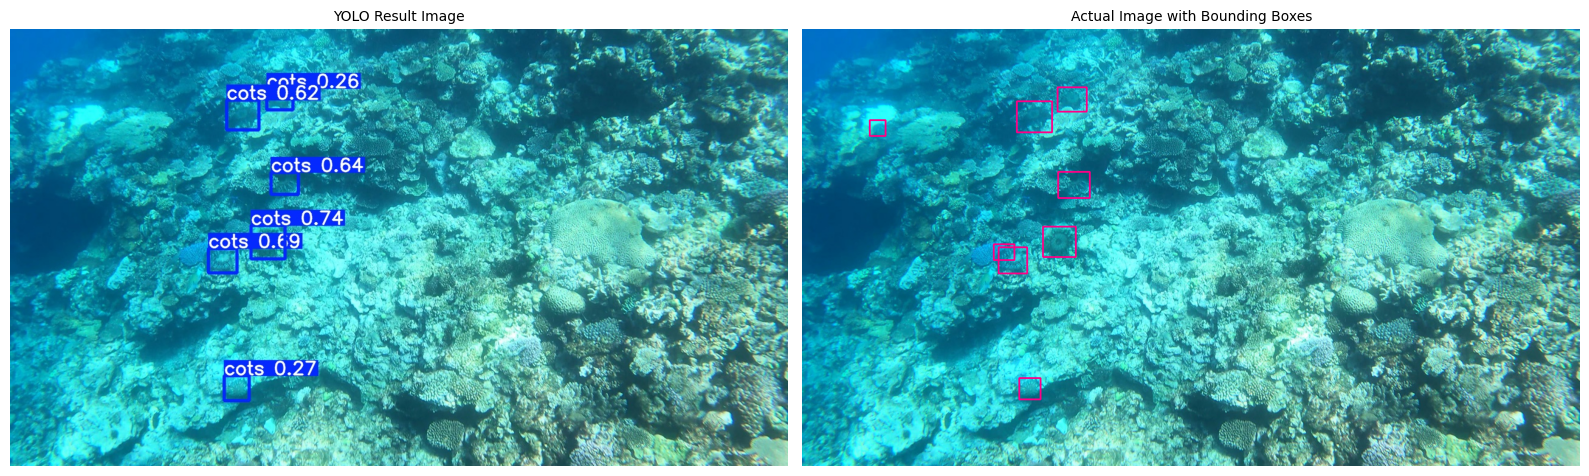

In [ ]:
# Load the result image from the saved directory
result_image_path = os.path.join(save_dir, image_files[0])
result_image = Image.open(result_image_path)

# Define the video and frame IDs
video_id = 1
frame_id = 5486

# Generate the image with bounding boxes
img_with_bb = show_COT_img_BB(video_id, frame_id)

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Display the YOLO result image
axs[0].imshow(result_image)
axs[0].set_title("YOLO Result Image", fontsize=10)
axs[0].axis('off')

# Display the actual image with bounding boxes
axs[1].imshow(img_with_bb)
axs[1].set_title("Actual Image with Bounding Boxes", fontsize=10)
axs[1].axis('off')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


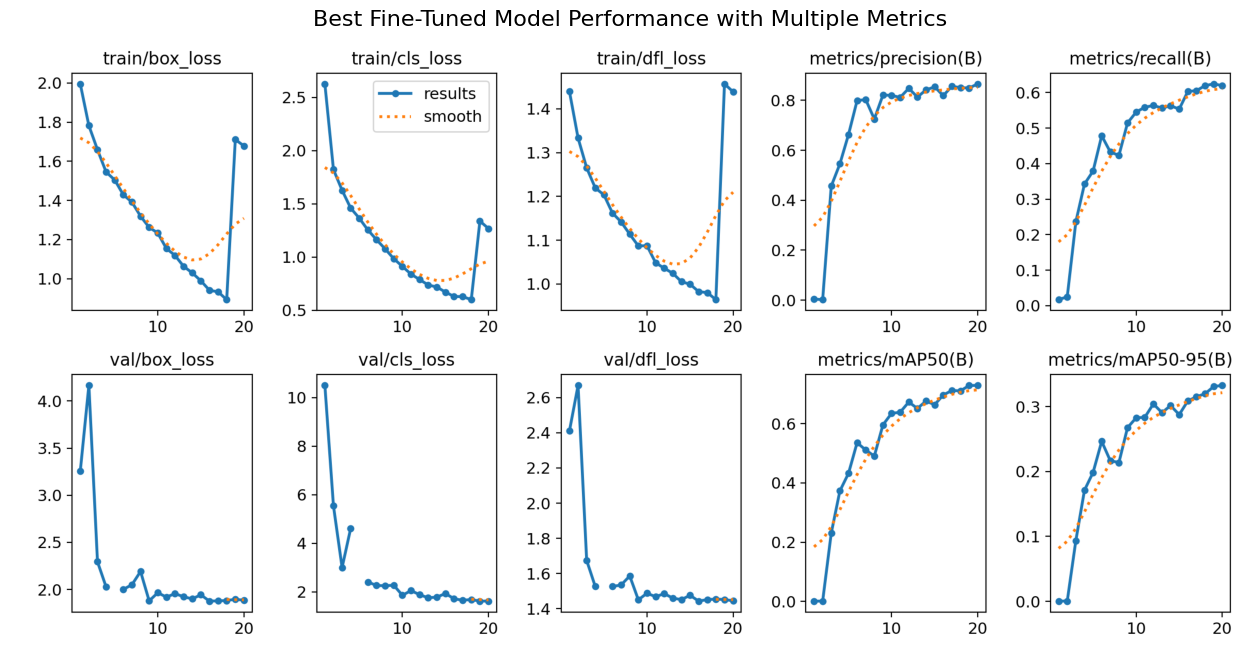

In [ ]:
# Load the image from the specified folder
img_path = os.path.join(image_folder, "results.png")
img = Image.open(img_path)

# Display the image
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title("Best Fine-Tuned Model Performance with Multiple Metrics", fontsize=16)
plt.show()


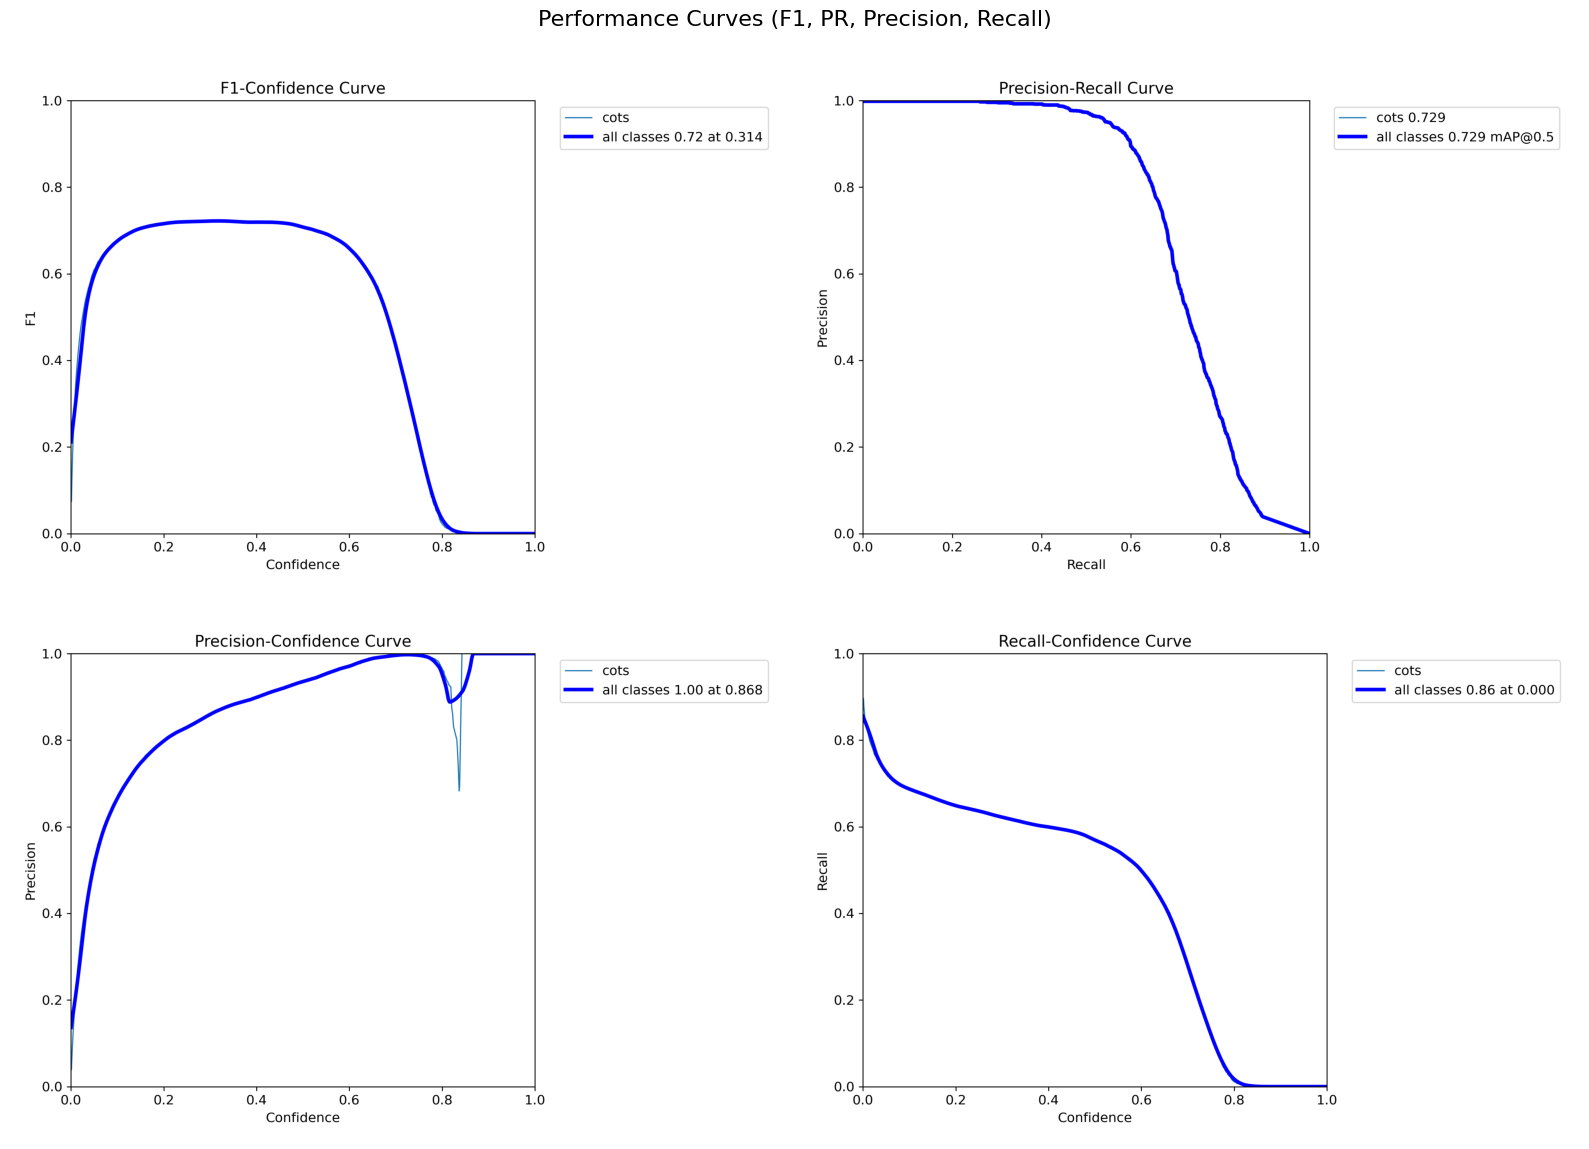

In [ ]:
# Define image paths
image_paths = [
    "/F1_curve.png",
    "/PR_curve.png",
    "/P_curve.png",
    "/R_curve.png"
]

# Create a 2x2 subplot for displaying images
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Iterate through each axis and image path
for i, ax in enumerate(axes.flat):
    # Open the image and display it
    img = Image.open(image_folder + image_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Set the title for the entire figure
plt.suptitle("Performance Curves (F1, PR, Precision, Recall)", fontsize=16)

# Adjust layout to prevent overlap and display the figure
plt.tight_layout()
plt.show()


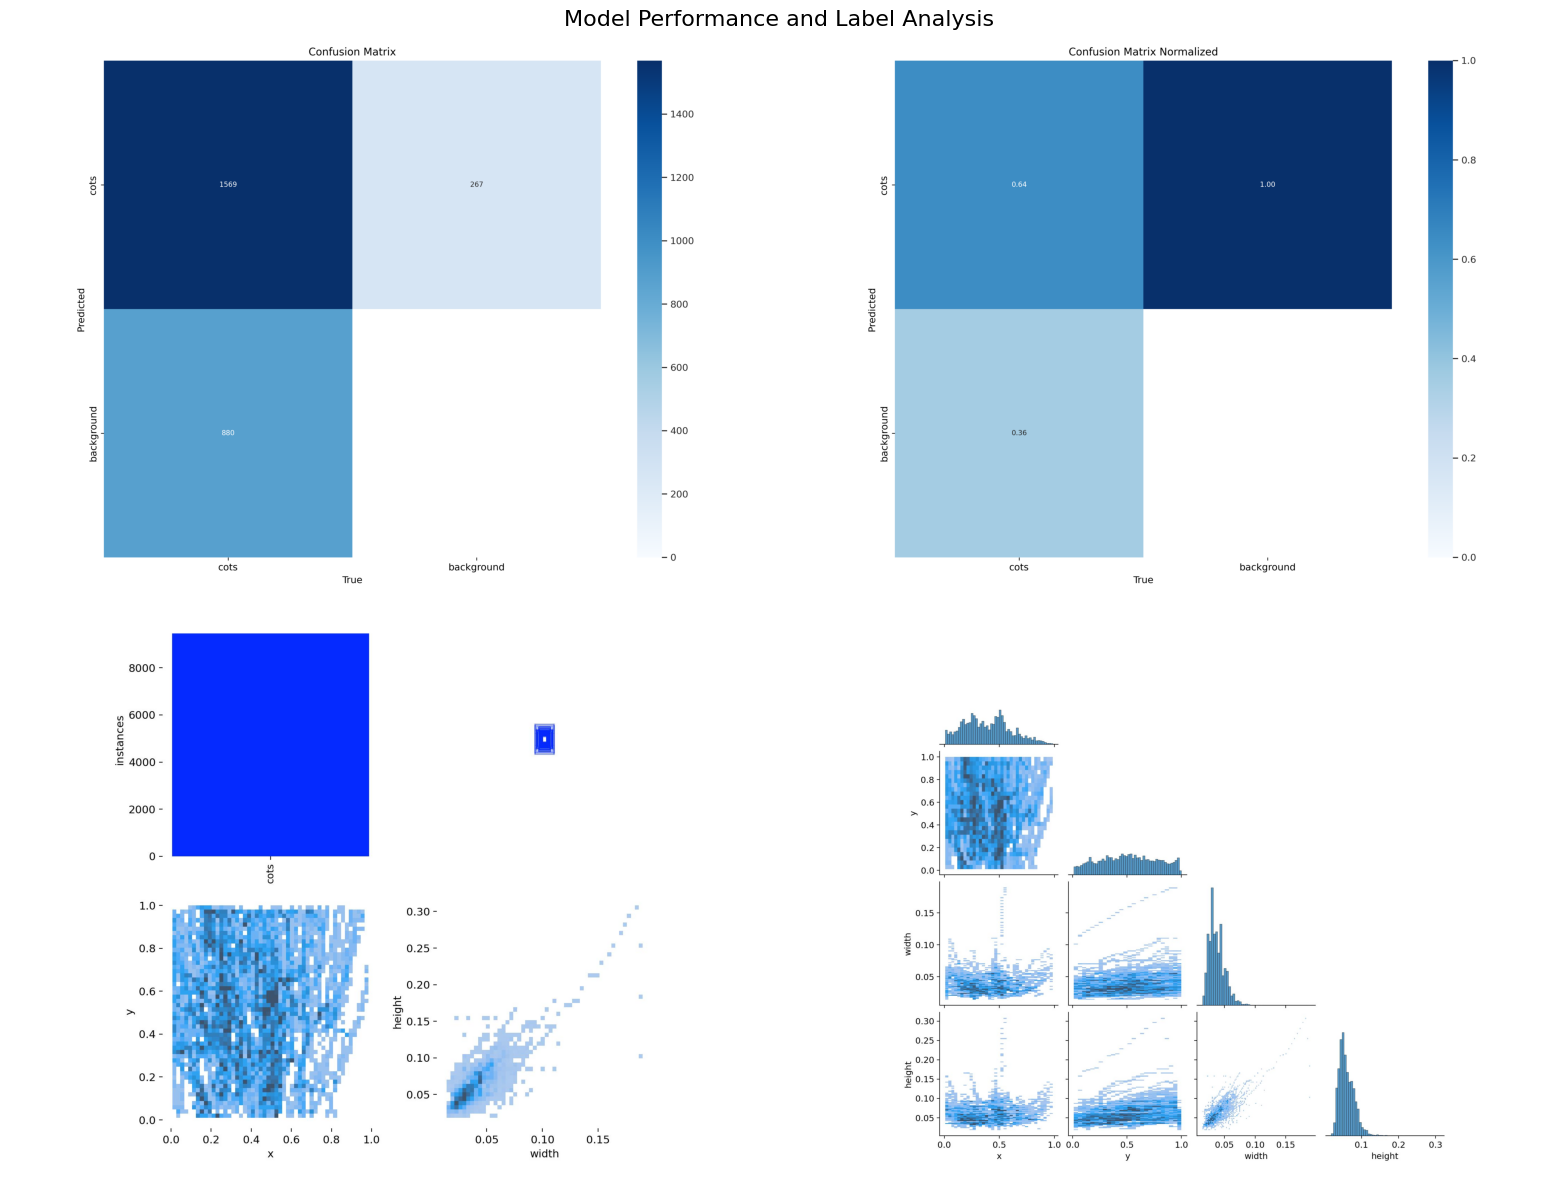

In [ ]:
# Define image paths
image_paths = [
    "/confusion_matrix.png",
    "/confusion_matrix_normalized.png",
    "/labels.jpg",
    "/labels_correlogram.jpg"
]

# Create a 2x2 subplot for displaying images
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Iterate through each axis and image path
for i, ax in enumerate(axes.flat):
    # Open the image and display it
    img = Image.open(image_folder + image_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Set the title for the entire figure
plt.suptitle("Model Performance and Label Analysis", fontsize=16)

# Adjust layout to prevent overlap and display the figure
plt.tight_layout()
plt.show()


# Conclusion:

In this project, we developed a deep learning model for real-time **Crown-of-Thorns Starfish (COTS)** detection using the state-of-the-art **YOLOv11** architecture from Ultralytics, combined with the CSIRO Crown-of-Thorns Starfish Detection dataset. While we explored enhancements such as CBAM (Convolutional Block Attention Module) and the introduction of dummy classes, these methods did not yield significant improvements during the fine-tuning process. However, it is possible that with increased computational resources, a larger YOLOv11 model, higher input image sizes, larger batch sizes, and extended training epochs, these techniques could prove more effective.

Our best-performing model currently achieves an **mAP50** of **0.729** and an inference speed of **7.0** ms per image (approximately **143** frames per second). It consists of **238 layers, 9,413,187 parameters,** and a computational complexity of **21.3 GFLOPs**. These performance metrics indicate that the model is highly suitable for real-time underwater COTS detection. It offers significant improvements in the efficiency of COTS removal efforts, contributing to the ongoing protection of coral reefs.




# Reference:
[1] Australian Institute of Marine Science. Reef monitoring sampling methods, n.d. Accessed: 2024-12-07.

[2] Jiajun Liu, Brano Kusy, Ross Marchant, Brendan Do, Torsten Merz, Joey Crosswell, Andy Steven, Nic Heaney, Karl von Richter, Lachlan Tychsen-Smith, David Ahmedt-Aristizabal, Mohammad Ali Armin, Geoffrey Carlin, Russ Babcock, Peyman Moghadam, Daniel Smith, Tim Davis, Kemal El Moujahid, Martin Wicke, and Megha Malpani. The CSIRO Crown-of-Thorn Starfish Detection Dataset, 2021.

[3] Ultralytics Team. Hyperparameter tuning guide. https://docs.ultralytics.com/guides/hyperparameter-tuning/#what-are-hyperparameters, 2024. Accessed: 2024-12-09.

[4] Ultralytics. YOLOv11: Object detection and image segmentation models. https://docs.ultralytics.com/models/yolo11/, 2024.

[5] UNESCO World Heritage Centre. Great Barrier Reef, n.d. Accessed: 2024-12-07.

[6] Sanghyun Woo, Jongchan Park, Joon-Young Lee, and In So Kweon. CBAM: Convolutional Block Attention Module, 2018.


In [ ]:
# Citation:

# @software{yolo11_ultralytics,
#   author = {Glenn Jocher and Jing Qiu},
#   title = {Ultralytics YOLO11},
#   version = {11.0.0},
#   year = {2024},
#   url = {https://github.com/ultralytics/ultralytics},
#   orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
#   license = {AGPL-3.0}
# }
